In [ ]:
!pip install tweet-preprocessor
!pip install emoji~=1.6.3
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'spark-3.3.0-bin-hadoop3'

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pandas as pd
import numpy as np
import preprocessor as p
import emoji
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
import textblob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
paths = "/content/drive/MyDrive/Cloud Course Data/Project/Comments_data/"

In [ ]:
comm_us = spark.read.csv(paths+"UScomments.csv", header='True', inferSchema='True')

In [ ]:
!pip install -U textblob
!python -m textblob.download_corpora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from textblob import TextBlob
# define udf to extract emojis
def extract_emojis_udf(s):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return list(set(''.join(re.findall(emoji_pattern, str(s)))))

stop_words = set(stopwords.words('english')) 
# define udf to tokenize and process text
def process_text_udf(s):
    s=s.lower()
    s=TextBlob(s)
    s = s.words.singularize() # Note that TextBlob performs stemming (singularize)
    s = [w for w in s if not w in stop_words]
    s = [re.sub(r'[^aA-zZ]+', ' ', w) for w in s if len(w)>1]
    return ' '.join(s)

# register udfs with Spark
extract_emojis = udf(extract_emojis_udf, ArrayType(StringType()))
process_text = udf(process_text_udf, StringType())

In [ ]:
# apply udfs to comm_us DataFrame and create new columns
comm_us = comm_us.withColumn("emojis_separated", extract_emojis(comm_us.comment_text))
comm_us = comm_us.withColumn("processed_comments", process_text(comm_us.comment_text))
comm_us.show()

+-----------+--------------------+-----+-------+----------------+--------------------+
|   video_id|        comment_text|likes|replies|emojis_separated|  processed_comments|
+-----------+--------------------+-----+-------+----------------+--------------------+
|XpVt6Z1Gjjo|Logan Paul it's y...|    4|      0|              []|logan paul yo big...|
|XpVt6Z1Gjjo|I've been followi...|    3|      0|              []| ve following sta...|
|XpVt6Z1Gjjo|Say hi to Kong an...|    3|      0|              []|say hi kong maverick|
|XpVt6Z1Gjjo| MY FAN . attendance|    3|      0|              []|      fan attendance|
|XpVt6Z1Gjjo|         trending 😉|    3|      0|            [😉]|            trending|
|XpVt6Z1Gjjo|#1 on trending AY...|    3|      0|              []|   trending ayyeeeee|
|XpVt6Z1Gjjo|The end though 😭...|    4|      0|    [😭, 🏻, 👍]|        end though  |
|XpVt6Z1Gjjo|#1 trending!!!!!!!!!|    3|      0|              []|            trending|
|XpVt6Z1Gjjo|Happy one year vl...|    3|      0| 

In [ ]:
out_df = comm_us.drop('emojis_separated')
out_df = out_df.drop('replies')

In [ ]:
out_df = out_df.filter(out_df.video_id.isNotNull())
out_df = out_df.filter(out_df.comment_text.isNotNull())
out_df = out_df.filter(out_df.likes.isNotNull())
out_df = out_df.filter(out_df.processed_comments.isNotNull())

In [ ]:
df_spark = out_df.filter(df_spark.name.isNotNull())
final_out_df = out_df.toPandas()

In [ ]:
out_df.write.csv("/content/content/drive/MyDrive/Cloud Course Data/Project/CleanedDataset2/cleaned_comments.csv", header=True, mode="overwrite")

In [ ]:
from pyspark.sql.functions import explode, col
df = comm_us
# Explode the emojis_separated column
df = df.select('video_id', 'emojis_separated').withColumn('emoji', explode('emojis_separated'))

# Group by video_id and emoji and count the occurrence of each emoji
df_grouped = df.groupBy('video_id', 'emoji').count()

# Get the top emoji with its count for each video
top_emoji = df_grouped.groupBy('video_id').agg({'count':'max'}).withColumnRenamed('max(count)', 'count') \
            .join(df_grouped, on=['video_id','count'], how='left').select('video_id', 'emoji', 'count')

# Show the top emoji with its count for each video
top_emoji.show()


+-----------+-----+-----+
|   video_id|emoji|count|
+-----------+-----+-----+
|TzyraAp3jaY|   👌|    4|
|K7pQsR8WFSo|   👍|    2|
|K7pQsR8WFSo|   😪|    2|
|dInwVhRtN4E|   😂|   10|
|rn5Xgak1zzA|   🚇|    1|
|rn5Xgak1zzA|   😂|    1|
|rn5Xgak1zzA|   😷|    1|
|rn5Xgak1zzA|   😕|    1|
|xPS7bqBePSs|   😍|   23|
|eHq6ZA6uKOg|   😭|    3|
|eHq6ZA6uKOg|   😍|    3|
|_r5eTelhpmQ|   👍|   15|
|Bo-qp-Zu0OY|   😭|    1|
|Bo-qp-Zu0OY|   😱|    1|
|g_ekn1gjBq0|   😂|    2|
|g_ekn1gjBq0|   💚|    2|
|g_ekn1gjBq0|   💜|    2|
|g_ekn1gjBq0|   🔥|    2|
|JkqTeQHFoBY|   👏|    5|
|WQjO1mMCPg4|   😂|   14|
+-----------+-----+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import collect_list
df = top_emoji
df_emoji_list = df.groupBy("video_id").agg(collect_list("emoji").alias("emojis"))

df_emoji_list.show()

+-----------+--------------------+
|   video_id|              emojis|
+-----------+--------------------+
|--JinobXWPk|                [😂]|
|-1fzGnFwz9M|                [😍]|
|-3AGlBYyLjo|                [😓]|
|-5sCWsLlTCI|                [😂]|
|-6Zc8Co2H3w|                [😂]|
|-AJyaVduxCc|                [😂]|
|-B9z3az6Axc|                [😂]|
|-C-LJUD2LWU|        [👍, 🏽, 😂]|
|-CEuQhqNzz4|                [🏀]|
|-Denciie5oA|                [😂]|
|-Egtbs-go4Q|[😂, 🙁, 😫, 😐, 😶]|
|-Ifnaxi2LQg|                [😍]|
|-Jdc7FXupWQ|                [😍]|
|-JmNKGfFj7w|                [😂]|
|-LoSw4o2zDQ|                [😍]|
|-PQBaYuvujw|                [😂]|
|-QL9dvmddYs|                [😍]|
|-SiRV2kWIxg|                [😂]|
|-UAdFerZMWc|    [👍, 😁, 🙂, 😭]|
|-_CmfnzbLFc|                [😍]|
+-----------+--------------------+
only showing top 20 rows



<ipython-input-118-f7b9dbcf7bbb>:14: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



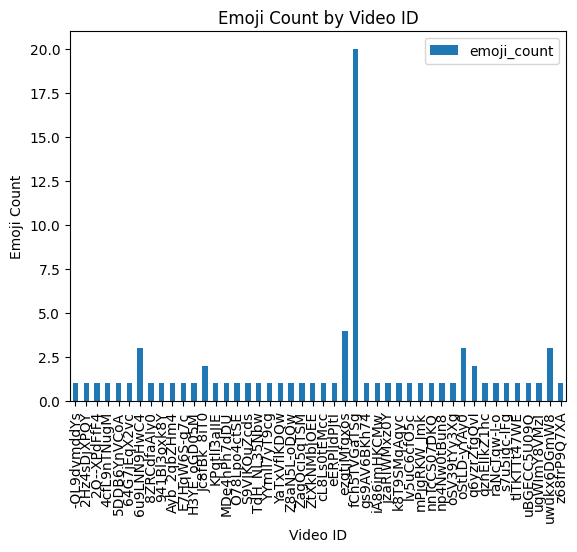

In [ ]:
import matplotlib.pyplot as plt

# Convert Spark dataframe to Pandas dataframe
df = df_emoji_list.sample(fraction=0.02, seed=42)

import pandas as pd
# convert spark dataframe to pandas dataframe
df_pd = df.toPandas()

# create a new column for emoji count
df_pd['emoji_count'] = df_pd['emojis'].apply(lambda x: len(x))

# group by video_id and sum the emoji counts
grouped_df = df_pd.groupby('video_id').sum()

# plot the bar chart
grouped_df.plot(kind='bar', y='emoji_count')

# set the labels and title
plt.xlabel('Video ID')
plt.ylabel('Emoji Count')
plt.title('Emoji Count by Video ID')

# show the plot
plt.show()
